In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
inspector = inspect(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:

measurement_columns = inspector.get_columns('Measurement')
for column in measurement_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

2017-08-23
2016-08-23
            prcp
date            
2016-08-23  0.00
2016-08-23   NaN
2016-08-23  1.79
2016-08-23  0.05
2016-08-23  0.15


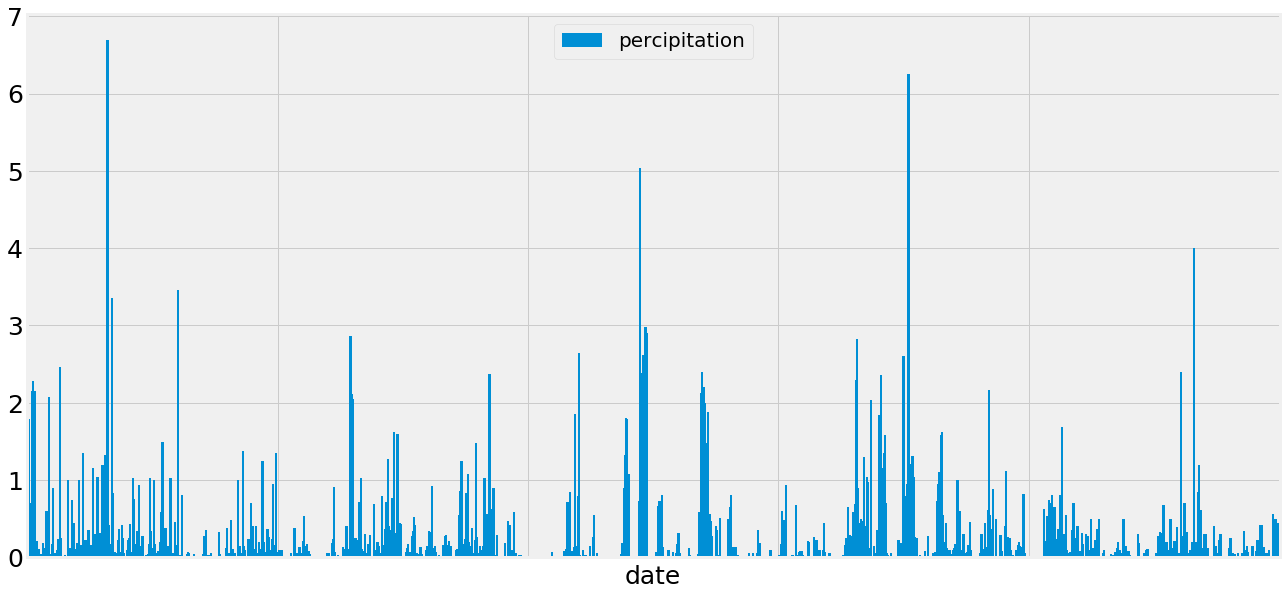

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date_query.date

year_ago = (dt.datetime.strptime(last_date,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

print(last_date)
print(year_ago)


# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).statement


# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.read_sql(prcp_query, conn)
df_prcp = df_prcp.set_index('date')


# # Sort the dataframe by date
df_prcp = df_prcp.sort_index()
print(df_prcp.head())

# Use Pandas Plotting with Matplotlib to plot the data

prcp_plot = df_prcp.plot(kind='bar', width=4, figsize=(20,10), fontsize=25)
prcp_plot.grid(True)
prcp_plot.xaxis.set_major_formatter(plt.NullFormatter())
plt.xlabel('date', fontsize=25)
plt.locator_params(axis='x', nbins=5)
plt.legend(['percipitation'], loc='upper center', fontsize=20)
plt.show()


![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
station_columns = inspector.get_columns('Station')
for column in station_columns:
    print(column['name'], column['type'])
numb_stations = session.query(Station.id).distinct().all()
station_count = len(numb_stations)
print(f"There are {station_count} stations")

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
There are 9 stations


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_station = station_activity[0][0]

most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
most_active_temps

[(54.0, 85.0, 71.66378066378067)]

       station  tobs
0  USC00519281  77.0
1  USC00519281  77.0
2  USC00519281  80.0
3  USC00519281  80.0
4  USC00519281  75.0


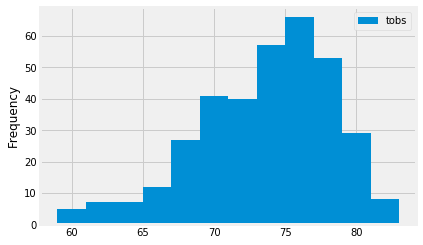

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

measurement_tobs_query = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date>=year_ago).statement
df_tobs = pd.read_sql(measurement_tobs_query, conn)

df_tobs.plot(kind='hist', bins=12)
plt.show()

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [54]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def last_year(date):
    a = (dt.datetime.strptime(date,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    return a

date = '2017-04-09'

trip_temp = calc_temps(last_year(date),date)
trip_temp

[(59.0, 74.36576889661164, 84.0)]

In [53]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# trip_temp_dict = {
#     'tobs_min': trip_temp[0][0],
#     'tobs_avg': trip_temp[0][1],
#     'tobs_max': trip_temp[0][2]
# }


# plt.bar(x="", height=(trip_temp[0][1]), yerr=([trip_temp[0][0]], [trip_temp[0][2]]))

In [41]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
